In [26]:
using LowRankApprox, PyPlot

In [23]:
n = 1000; p = 10000; F_ST = 0.01;
X_tilde = randn(n,p);
s = floor(Int,n/2)
Z = [ones(s);-ones(n-s)];
f = randn(p) * sqrt(F_ST);
X = X_tilde + Z*f';

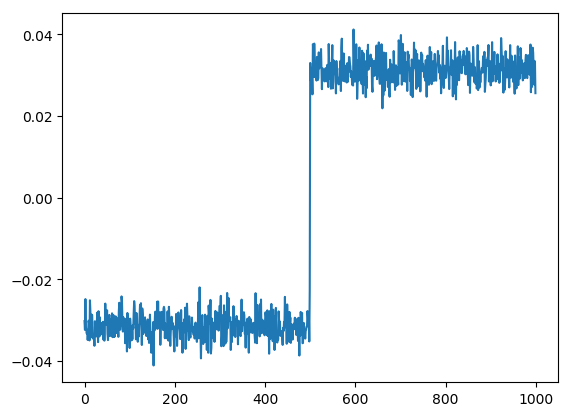

1×1000 RowVector{Float64,Array{Float64,1}}:
 333.531  131.137  130.953  130.832  …  69.0706  69.0262  68.8906  68.5315

In [46]:
F = psvdfact(X);
plot(F[:U][:,1]);
F[:S]'

We have found a population structure by simple singular value decomposition if $F_{ST} = 0.01$. For reference, typical values of $F_{ST}$ for human populations are $\approx 0.1$ for populations from different continents, $F_{ST} \approx 0.01$ for populations on the same continent, and $F_{ST} < 0.01$ for subpopulations within the same country.

In [47]:
t = 140;
p = Int64(t*(t+1) /2);
X_tilde = randn(n,p);
for i = 1:t
    range = Array{Int64,1}((i-1)*i/2 + (1:i));
    X_tilde[:,range] = repmat(randn(n),1,length(range));
end
f = randn(p) * sqrt(F_ST);
X = X_tilde + Z*f';

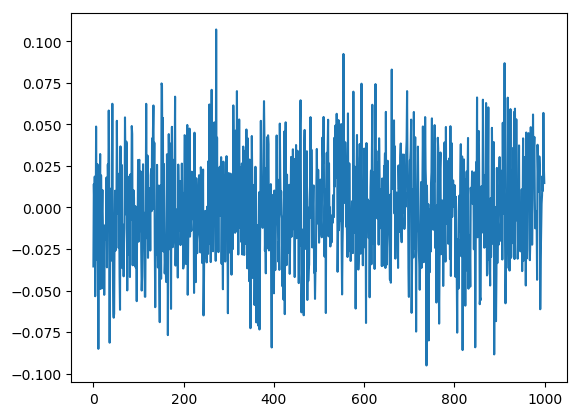

1×141 RowVector{Float64,Array{Float64,1}}:
 434.582  419.037  409.863  404.943  …  56.9903  49.0506  40.5886  28.7029

In [48]:
F = psvdfact(X);
plot(F[:U][:,1]);
F[:S]'

Note that the above experiment is based on very extreme case. There exist $1, \cdots, 140$ SNPs perfectly correlated with each other, respectively. Now we move on to less extreme case.

In [68]:
p = 9000; k = 5;
X_tilde = randn(n,p);
for i = 1:k
    range = (i-1) * Int(p/k) + (1:Int(p/k));
    X_tilde[:,range] = reshape(repmat(randn(n,Int(p/k/i)),i,1),n,Int(p/k));
end
f = randn(p) * sqrt(F_ST);
X = X_tilde + Z*f';

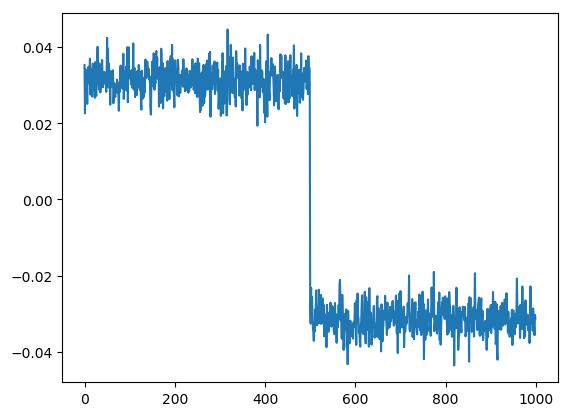

1×1000 RowVector{Float64,Array{Float64,1}}:
 317.706  151.554  150.584  150.32  …  44.6873  44.5311  44.28  44.0249

In [69]:
F = psvdfact(X);
plot(F[:U][:,1]);
F[:S]'

Therefore, we conclude that if linkage disequilibrium is not very large (LD score $\lesssim 5$) then we can find a confounder by PCA or SVD. Now let's consider the case when $f \sim N(0,F_{ST}V)$ for varying choice of $V$.

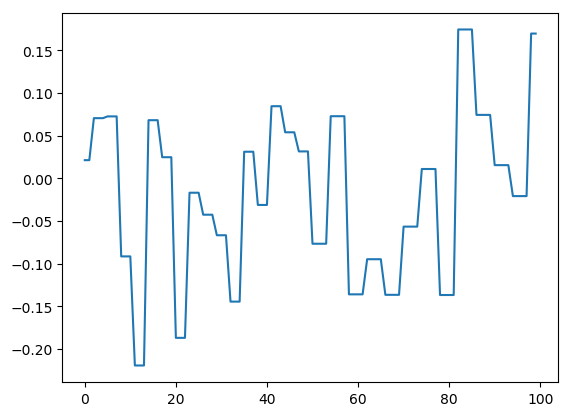

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x123d54390>

In [78]:
for i = 1:5
    range = (i-1) * Int(p/k) + (1:Int(p/k));
    f[range] = reshape(repmat(randn(Int(p/k/i))',i,1),1,Int(p/k))[:];
end
f = f * sqrt(F_ST);
plot(f[5351:5450])

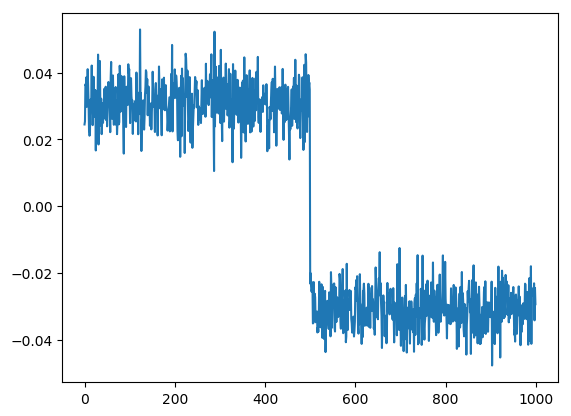

1×1000 RowVector{Float64,Array{Float64,1}}:
 321.366  151.48  150.542  150.346  …  44.659  44.5267  44.2893  43.9937

In [79]:
X = X_tilde + Z*f';
F = psvdfact(X);
plot(F[:U][:,1]);
F[:S]'

It seems like the plot above contains a more fluctuating graph, but everything still looks fine.

In [136]:
h_g2 = 1/2; sigma_s2 = 1/6; sigma_e2 = 1 - h_g2 - sigma_s2;

How we will sample $\beta \sim N(0,(h_g^2/p) I_p)$, $\gamma \sim N(0,\sigma_s^2)$, $\epsilon \sim N(0,\sigma_e^2 I_n)$ with the above setting and get $y = X\beta + Z\gamma + \epsilon$.

In [130]:
function simple_linear_regression(x,y,intercept = Inf)
    temp = [ones(length(x)) x];
    out = (temp' * temp) \ (temp' * y);
    if(intercept < Inf)
        out = [intercept; sum(x.*(y-intercept))/sum(x.^2)];
    end
    return out
end
function ld_score_regression(l,chisq, size = 100)
    scatter(l, chisq, s = 1);
    m = ceil(Int, maximum(l))
    range = linspace(0,m,size);
    l_binned = linspace((range[1] + range[2])/2, (range[end] + range[end-1])/2, length(range) - 1);
    chisq_binned = 1.0 * ones(length(l_binned));
    for i = 1:length(l_binned)
        chisq_binned[i] = mean(chisq[find((l .>= range[i]) .& (l .<= range[i+1]))]);
    end
    scatter(l_binned, chisq_binned, color = "red", s = 5);
    return simple_linear_regression(l,chisq)
end
function sim(h_g2,sigma_s2)
    sigma_e2 = 1 - h_g2 - sigma_s2;
    beta = randn(p) * sqrt(h_g2/p);
    gamma = randn() * sqrt(sigma_s2);
    eps = randn(n) * sqrt(sigma_e2);
    y = X * beta + Z * gamma + eps;
    beta_tilde = X_tilde'*y/n;
    chisq = n*beta_tilde.^2;
    l = [ones(1800);ones(1800)*2;ones(1800)*3;ones(1800)*4;ones(1800)*5];
    out = ld_score_regression(l,chisq);
    return beta, gamma, eps, y, chisq, l, out
end


sim (generic function with 1 method)

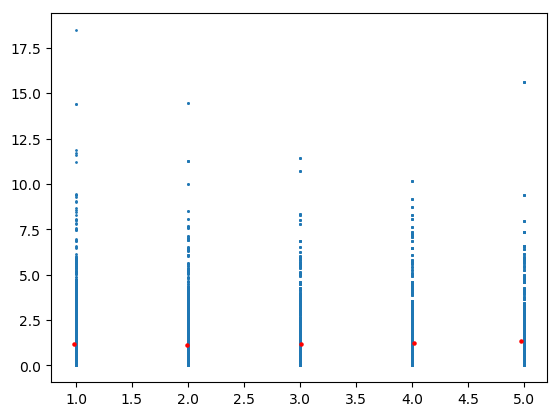

3×2 Array{Any,2}:
  "simulation"   "true"  
 1.06115        1.0      
 0.0526756      0.0555556

In [144]:
["simulation" "true"; sim(h_g2,sigma_s2)[end] [1;n*h_g2/p]]

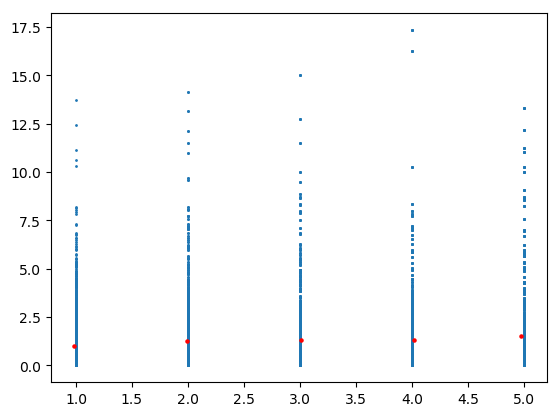

3×2 Array{Any,2}:
  "simulation"   "true" 
 0.957495       1.0     
 0.111421       0.111111

In [150]:
h_g2 = 1; sigma_s2 = 0;
["simulation" "true"; sim(h_g2,sigma_s2)[end] [1;n*h_g2/p]]